In [1155]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import gensim
import numpy as np
import pandas as pd
import spacy
import math

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction import text

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('merged_jokes.csv', index_col=0)

In [ ]:
df

In [ ]:
df[ df['selftext'].isnull() ]

In [ ]:
# Use spacy model for our NLP Pipeline
nlp = spacy.load('en_core_web_lg')

# Load the stopwords (common words that are not important)
stop_words = stopwords.words('english')

In [ ]:
df['joke'] = df['title'] + ' ' + df['selftext']

In [ ]:
df.iloc[0]['joke']

In [ ]:
df

In [ ]:
df['joke_lower'] = df['joke'].apply(lambda x: x.lower())

In [ ]:
df

In [ ]:
df['joke_no_num'] = df['joke_lower'].str.replace('\d+', '')

In [ ]:
df

In [ ]:
df['joke_no_punct'] = df['joke_no_num'].str.replace('[^\w\s]','')

In [ ]:
df

In [ ]:
df['joke_no_stopwords'] = df['joke_no_punct'].apply(lambda words: ' '.join(word for word in words.split() if word not in stop_words))

In [ ]:
df

In [ ]:
text = [words.split() for words in df['joke_no_stopwords']]

In [ ]:
len(text)

In [ ]:
bigram = gensim.models.Phrases(text)
texts = [bigram[line] for line in text]

In [ ]:
texts

In [ ]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
corpus

### LSI

In [ ]:
j, coherence = [], []

for i in range(9,15):
    lsimodel = LsiModel(corpus=corpus, num_topics=i, id2word=dictionary)
    lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
    lsi_coherence = CoherenceModel(topics=lsitopics[:i], texts=texts, dictionary=dictionary).get_coherence()
    j.append(i)
    coherence.append(lsi_coherence)
    print(i, lsi_coherence)

In [ ]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=dictionary)
lsimodel.show_topics(num_topics=5)

In [ ]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
lsimodel.show_topics(num_topics=10)

## HDP

In [ ]:
# Here is how you use the hdpmodel
# Recall from discussion that HDP is unsupervised so you don't need to predefine the number of topics

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()

In [ ]:
hdpmodel.show_topics(num_topics=5)

## LDA

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)
ldamodel.show_topics()

### Coherence

In [ ]:
# Next we extract each words to measure and compare model performance
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [ ]:
# Then we get the coherence scores. Higher coherence, better results.
lsi_coherence = CoherenceModel(topics=lsitopics[:10],texts=texts,dictionary=dictionary,window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:20],texts=texts,dictionary=dictionary,window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics[:10],texts=texts,dictionary=dictionary,window_size=10).get_coherence()

In [ ]:
# Then we compare a bar chart to compare the three models
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2,tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [ ]:
# LSI wins
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence], ['LSI', 'HDP', 'LDA'])

### Lemmatize

In [ ]:
df

In [ ]:
samp = nlp(df.iloc[1]['joke_no_stopwords'])
samp

In [ ]:
lemmatized = [w.lemma_ for w in samp if w.pos_ == 'NOUN']
lemmatized

In [ ]:
lemma_text = []

for i in range(len(df)):
    joke = nlp(df.iloc[i]['joke_no_stopwords'])
    lemmatized = [w.lemma_ for w in joke if (w.pos_ == 'NOUN') & (len(w.text) < 15) ]
    lemma_text.append(lemmatized)

In [ ]:
len(lemma_text)

In [ ]:
lemma_text

In [ ]:
bigram = gensim.models.Phrases(lemma_text)
lemma_text = [bigram[line] for line in lemma_text]

In [ ]:
dictionary = Dictionary(lemma_text)
corpus = [dictionary.doc2bow(text) for text in lemma_text]

In [ ]:
corpus

In [ ]:
j, coherence = [], []

for i in range(2,11):
    lsimodel = LsiModel(corpus=corpus, num_topics=i, id2word=dictionary)
    lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
    lsi_coherence = CoherenceModel(topics=lsitopics[:i], texts=lemma_text, dictionary=dictionary).get_coherence()
    j.append(i)
    coherence.append(lsi_coherence)
    print(i, lsi_coherence)

In [ ]:
j, coherence = [], []

for i in range(2,11):
    ldamodel = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary)
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
    lda_coherence = CoherenceModel(topics=ldatopics[:i], texts=lemma_text, dictionary=dictionary).get_coherence()
    j.append(i)
    coherence.append(lda_coherence)
    print(i, lda_coherence)

In [ ]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=dictionary)
lsimodel.show_topics()

In [ ]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics(num_words=5)

In [ ]:
hdpmodel.show_topics(num_words=5, num_topics=1000)

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, iterations=100)
ldamodel.show_topics()

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=3, id2word=dictionary, iterations=3000)
ldamodel.show_topics()

In [ ]:
# Next we extract each words to measure and compare model performance
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [ ]:
# Then we get the coherence scores. Higher coherence, better results.
lsi_coherence = CoherenceModel(topics=lsitopics[:5],texts=lemma_text,dictionary=dictionary,window_size=5).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:20],texts=lemma_text,dictionary=dictionary,window_size=5).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics[:5],texts=lemma_text,dictionary=dictionary,window_size=5).get_coherence()

In [ ]:
# LSI wins
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence], ['LSI', 'HDP', 'LDA'])

## LDA w/ vectorization

In [944]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import decomposition

from itertools import chain, combinations

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
df = pd.read_csv('merged_jokes.csv', index_col=0)

In [ ]:
df

### Remove 'edit'

In [ ]:
df['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:').sum()

In [ ]:
df[ df['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:') ]

In [ ]:
df['new_selftext'] = df['selftext'].apply( lambda x: re.split("\n+[Ee]*[Dd]*[Ii]*[Tt]*:", x)[0] )

In [ ]:
df[ df['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:') ]

In [ ]:
string = "I'm a faux pa.\n\nEdit: This took off a lot better than I expected.\n\nI feel like a father figure now"

In [ ]:
re.split("\n+[Ee]*[Dd]*[Ii]*[Tt]*:", string)[0]

In [ ]:
df

In [ ]:
df['new_selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:').sum()

In [ ]:
df['joke'] = df['title'] + ' ' + df['new_selftext']

In [ ]:
df

In [ ]:
df.iloc[0]['joke']

In [ ]:
df['joke_lower'] = df['joke'].apply(lambda x: x.lower())

In [ ]:
df

In [ ]:
df['joke_no_num'] = df['joke_lower'].str.replace('\d+', '')

In [ ]:
df

In [ ]:
df['joke_no_punct'] = df['joke_no_num'].str.replace('[^\w\s]','')

In [ ]:
df['joke_no_stopwords'] = df['joke_no_punct'].apply(lambda words: ' '.join(word for word in words.split() if word not in stop_words))

In [ ]:
df

In [ ]:
X_train, X_test = train_test_split(df['joke_no_stopwords'], test_size=0.25, random_state=13)

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
# stemmer = PorterStemmer()

### Test different lemmatizers

In [ ]:
def nltk_tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if ( len(word)<15 )]
    lemmas = [wnl.lemmatize(word) for word in tokens]
#     stems = [stemmer.stem(word) for word in tokens]
    return lemmas

In [ ]:
# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)
#     return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# def spacy_tokenize1(text):
#     joke = nlp(text)
#     lemmatized = [w.lemma_ for w in joke if (w.pos_ in pos[0]) & (len(w.text) < 15) & (len(w.text) >= 2) ]
#     return lemmatized

# def spacy_tokenize2(text):
#     joke = nlp(text)
#     lemmatized = [w.lemma_ for w in joke if (w.pos_ in pos[1]) & (len(w.text) < 15) & (len(w.text) >= 2) ]
#     return lemmatized

# def spacy_tokenize3(text):
#     joke = nlp(text)
#     lemmatized = [w.lemma_ for w in joke if (w.pos_ in pos[2]) & (len(w.text) < 15) & (len(w.text) >= 2) ]
#     return lemmatized

# def spacy_tokenize4(text):
#     joke = nlp(text)
#     lemmatized = [w.lemma_ for w in joke if (w.pos_ in pos[3]) & (len(w.text) < 15) & (len(w.text) >= 2) ]
#     return lemmatized

# def spacy_tokenize5(text):
#     joke = nlp(text)
#     lemmatized = [w.lemma_ for w in joke if (w.pos_ in pos[4]) & (len(w.text) < 15) & (len(w.text) >= 2) ]
#     return lemmatized

# def spacy_tokenize6(text):
#     joke = nlp(text)
#     lemmatized = [w.lemma_ for w in joke if (w.pos_ in pos[5]) & (len(w.text) < 15) & (len(w.text) >= 2) ]
#     return lemmatized

# def spacy_tokenize7(text):
#     joke = nlp(text)
#     lemmatized = [w.lemma_ for w in joke if (w.pos_ in pos[6]) & (len(w.text) < 15) & (len(w.text) >= 2) ]
#     return lemmatized


# # def spacy_tokenize(text):
# #     joke = nlp(text)
# #     lemmatized = [w.lemma_ for w in joke if (w.pos_ == 'NOUN') & (len(w.text) < 15) & (len(w.text) >= 2) ]
# #     return lemmatized

In [ ]:
def spacy_tokenize(text):
    joke = nlp(text)
    lemmatized = [w.lemma_ for w in joke if (w.pos_ == 'NOUN') & (len(w.text) < 15) & (len(w.text) >= 2)]
    return lemmatized

In [ ]:
# pos = [list(x) for x in list(powerset(['NOUN', 'ADJ', 'VERB'])) if list(x) != []]
# pos

In [ ]:
# df.iloc[0]['joke_no_stopwords']

In [ ]:
# nltk.word_tokenize(df.iloc[0]['joke_no_stopwords'])

In [ ]:
# nltk_tokenize(df.iloc[0]['joke_no_stopwords'])

In [ ]:
# spacy_tokenize(df.iloc[0]['joke_no_stopwords'])

### Use spacy lemmatizer!

In [ ]:
# Get tf-idf scores

vectorizer_tf = TfidfVectorizer(tokenizer=spacy_tokenize1, stop_words='english', max_features=1000)
tf_vectors_train = vectorizer_tf.fit_transform(X_train)

In [ ]:
# Get term counts

# vectorizer_count = CountVectorizer(tokenizer=spacy_tokenize, stop_words='english')
# count_vectors_train = vectorizer_count.fit_transform(X_train)

In [ ]:
tf_vectors_train.A.shape

In [ ]:
# count_vectors_train.A.shape

In [ ]:
# X_train.iloc[3]

In [ ]:
# count_vectors_train.A[3][393]

In [ ]:
# vectorizer_tf.get_feature_names()[393]

In [ ]:
# np.argmax(count_vectors_train.A, axis=1)[3]

In [ ]:
vectorizer_tf.get_feature_names()

In [ ]:
# vectorizer_count.get_feature_names()

In [ ]:
# Instanstiate LDA model

lda = decomposition.LatentDirichletAllocation(n_components=10, n_jobs=-1, max_iter=100)

In [ ]:
# Train LDA model

W1 = lda.fit_transform(tf_vectors_train)
H1 = lda.components_

In [ ]:
W1 # document-topic matrix

In [ ]:
H1 # topic-word matrix

In [ ]:
# Get top words for each topic

num_words = 15

vocab = np.array(vectorizer_tf.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]] # top_words(t)
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [ ]:
topics

In [ ]:
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Docu" + ' ' + str(i) for i in range(len(X_train))]

df_doc_topic = pd.DataFrame( np.round(W1,2), columns=colnames, index=docnames )
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [ ]:
# Training set used

df_doc_topic

## New dataframe

In [ ]:
df_new = pd.read_csv('jokes_hotnewtop.csv')
df_new = df_new.iloc[:,2:]

In [ ]:
len(df_new)

In [ ]:
df_new.isnull().sum()

In [ ]:
len(df_new)

In [ ]:
df_new = df_new.drop_duplicates()

In [ ]:
len(df_new)

In [ ]:
df_new

In [ ]:
df_new['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:').sum()

In [ ]:
df_new[ df_new['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:') ]

In [ ]:
df_new['new_selftext'] = df_new['selftext'].apply( lambda x: re.split("\n+[Ee]*[Dd]*[Ii]*[Tt]*:", x)[0] )

In [ ]:
string = "I'm a faux pa.\n\nEdit: This took off a lot better than I expected.\n\nI feel like a father figure now"

In [ ]:
re.split("\n+[Ee]*[Dd]*[Ii]*[Tt]*:", string)[0]

In [ ]:
df_new

In [ ]:
df_new['new_selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:').sum()

In [ ]:
df_new['joke'] = df_new['title'] + ' ' + df_new['new_selftext']

In [ ]:
df_new

In [ ]:
df_new['joke_lower'] = df_new['joke'].apply(lambda x: x.lower())

In [ ]:
df_new

In [ ]:
df_new['joke_no_num'] = df_new['joke_lower'].str.replace('\d+', '')

In [ ]:
df_new

In [ ]:
df_new['joke_no_punct'] = df_new['joke_no_num'].str.replace('[^\w\s]','')

In [954]:
# define new stop_words

new = ['youre','yea','anyways','one','said','whenever','kinda', 'edit','got','nt','(punchline)','sht','would','later','meant','agrees', 'everywhere',
'k','thanks','much','whereby','keep','go','always','youll','one','sure','know', 'really', 'see','whaaat','c','behind','even','oh','next','yes'
'went','came','nearly','else','somebody','thought','put','well','ive','whats', 'recently', 'thats','next','later','also','every'
'meanwhile','took','im','xb','heres','ok','dunno','thinks','subreddit','reddit','admins','along','especially','obviously','somethings',
'coming','finally','tells','says','made','hes','really','get','said','th','say','na','ca','minute','one','sub','comment','word','thing','every','shall','could']

stop_words.extend(new)

In [955]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
df_new['joke_no_stopwords'] = df_new['joke_no_punct'].apply(lambda words: ' '.join(word for word in words.split() if word not in stop_words))

In [ ]:
df_new

In [ ]:
# X_train, X_test = train_test_split(df_new['joke_no_stopwords'], test_size=0.1, random_state=13)

## Topic modelling with df_new (LDA)

In [972]:
def spacy_tokenize(text):
    joke = nlp(text)
    lemmatized = [w.lemma_ for w in joke if (w.pos_ == 'NOUN') & (len(w.text) < 15) & (len(w.text) >= 2)]
    return lemmatized

In [ ]:
# Get tf-idf scores

vectorizer_tf = TfidfVectorizer(tokenizer=spacy_tokenize, stop_words=stop_words, max_features=1000)
tf_vectors_train = vectorizer_tf.fit_transform(df_new['joke_no_stopwords'])

In [ ]:
# Get term counts

# vectorizer_count = CountVectorizer(tokenizer=spacy_tokenize, stop_words='english')
# count_vectors_train = vectorizer_count.fit_transform(X_train)

In [ ]:
tf_vectors_train.A.shape

In [ ]:
vectorizer_tf.get_feature_names()

In [ ]:
# vectorizer_count.get_feature_names()

In [ ]:
# Instanstiate LDA model

lda = decomposition.LatentDirichletAllocation(n_components=10, n_jobs=-1, random_state=13)

In [ ]:
# Train LDA model

W1 = lda.fit_transform(tf_vectors_train)
H1 = lda.components_

In [ ]:
W1 # document-topic matrix

In [ ]:
H1 # topic-word matrix

In [ ]:
# Get top words for each topic

num_words = 15

vocab = np.array(vectorizer_tf.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]] # top_words(t)
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [ ]:
topics

In [ ]:
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Docu" + ' ' + str(i) for i in range(len(df_new['joke_no_stopwords']))]

df_doc_topic = pd.DataFrame( np.round(W1,2), columns=colnames, index=docnames )
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [ ]:
# Entire dataset used

df_doc_topic

## Topic modelling with df_new (NMF)

In [946]:
def spacy_tokenize(text):
    joke = nlp(text)
    lemmatized = [w.lemma_ for w in joke if (w.pos_ == 'NOUN') & (len(w.text) < 15) & (len(w.text) >= 2)]
    return lemmatized

In [ ]:
# Get tf-idf scores

vectorizer_tf = TfidfVectorizer(tokenizer=spacy_tokenize, stop_words=stop_words)
tf_vectors_train = vectorizer_tf.fit_transform(df_new['joke_no_stopwords'])

In [ ]:
# Get term counts

# vectorizer_count = CountVectorizer(tokenizer=spacy_tokenize, stop_words='english')
# count_vectors_train = vectorizer_count.fit_transform(X_train)

In [ ]:
tf_vectors_train.A.shape

In [ ]:
vectorizer_tf.get_feature_names()

In [ ]:
# vectorizer_count.get_feature_names()

In [ ]:
# Instanstiate NMF model

nmf = decomposition.NMF(n_components=4, random_state=13)

In [ ]:
# Train LDA model

W1 = nmf.fit_transform(tf_vectors_train)
H1 = nmf.components_

In [ ]:
W1 # document-topic matrix

In [ ]:
H1 # topic-word matrix

In [ ]:
# Get top words for each topic

num_words = 10

vocab = np.array(vectorizer_tf.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]] # top_words(t)
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [ ]:
topics

In [ ]:
colnames = ["Topic" + str(i) for i in range(nmf.n_components)]
docnames = ["Docu" + ' ' + str(i) for i in range(len(df_new['joke_no_stopwords']))]

df_doc_topic = pd.DataFrame( np.round(W1,2), columns=colnames, index=docnames )
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [ ]:
# Entire dataset used

df_doc_topic

### Wordcloud

In [ ]:
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,norm='l2',encoding='latin-1',ngram_range=(1,1), 
#                         stop_words=stop_words)
# features = tfidf.fit_transform(transformed_texts_3)

# d = tfidf.vocabulary_

In [ ]:
# Get tf-idf scores

vectorizer_tf = TfidfVectorizer(tokenizer=spacy_tokenize, stop_words=stop_words)
tf_vectors_train = vectorizer_tf.fit_transform(df_new['joke_no_stopwords'])

d = vectorizer_tf.vocabulary_ # dictionary key:value <==> word:index

In [ ]:
wordcloud = WordCloud(background_color='white', max_words=2000, width=1024, height= 720).generate_from_frequencies(d)
plt.figure(dpi=500, figsize=(20,8))
plt.title('WordCloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
wordcloud_df = pd.DataFrame(data=tf_vectors_train.A, columns= vectorizer_tf.get_feature_names())

In [ ]:
wordcloud_df

In [ ]:
wordcloud_df.sum(axis=0)

In [ ]:
wordcloud = WordCloud(background_color='white', max_words=2000, width=1024, height= 720).generate_from_frequencies(wordcloud_df.sum(axis=0))
plt.figure(dpi=500, figsize=(20,8))
plt.title('WordCloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Jokes only

In [ ]:
df1 = pd.read_csv('jokes_new.csv')
df2 = pd.read_csv('jokes_hot.csv')
df3 = pd.read_csv('jokes.csv')

In [ ]:
df_jokes_only = pd.concat([df1,df2,df3], axis=0)

In [ ]:
df_jokes_only = df_jokes_only.iloc[:,1:]
df_jokes_only

In [ ]:
df_new = df_jokes_only.drop_duplicates()

In [ ]:
len(df_new)

In [ ]:
df_new

In [ ]:
df_new = df_new.dropna()

In [ ]:
df_new.isnull().sum()

In [ ]:
len(df_new)

In [ ]:
df_new

In [ ]:
df_new['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:').sum()

In [ ]:
df_new[ df_new['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:') ]

In [ ]:
df_new['new_selftext'] = df_new['selftext'].apply( lambda x: re.split("\n+[Ee]*[Dd]*[Ii]*[Tt]*:", x)[0] )

In [ ]:
string = "I'm a faux pa.\n\nEdit: This took off a lot better than I expected.\n\nI feel like a father figure now"

In [ ]:
re.split("\n+[Ee]*[Dd]*[Ii]*[Tt]*:", string)[0]

In [ ]:
df_new

In [ ]:
df_new['new_selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:').sum()

In [ ]:
df_new['joke'] = df_new['title'] + ' ' + df_new['new_selftext']

In [ ]:
df_new

In [ ]:
df_new['joke_lower'] = df_new['joke'].apply(lambda x: x.lower())

In [ ]:
df_new

In [ ]:
df_new['joke_no_num'] = df_new['joke_lower'].str.replace('\d+', '')

In [ ]:
df_new

In [ ]:
df_new['joke_no_punct'] = df_new['joke_no_num'].str.replace('[^\w\s]','')

In [ ]:
stop_words

In [ ]:
df_new['joke_no_stopwords'] = df_new['joke_no_punct'].apply(lambda words: ' '.join(word for word in words.split() if word not in stop_words))

In [ ]:
df_new

In [ ]:
df_jokes_only = df_new.copy()

In [ ]:
df_jokes_only

In [ ]:
# Get tf-idf scores

vectorizer_tf = TfidfVectorizer(tokenizer=spacy_tokenize, stop_words=stop_words)
tf_vectors_train = vectorizer_tf.fit_transform(df_jokes_only['joke_no_stopwords'])

# d = vectorizer_tf.vocabulary_ # dictionary key:value <==> word:index

In [ ]:
wordcloud_df = pd.DataFrame(data=tf_vectors_train.A, columns= vectorizer_tf.get_feature_names())

In [ ]:
wordcloud_df

In [ ]:
wordcloud_df.sum(axis=0).nlargest(20)

In [ ]:
wordcloud = WordCloud(background_color='white', max_words=2000, width=1024, height= 720).generate_from_frequencies(wordcloud_df.sum(axis=0))
plt.figure(dpi=500, figsize=(20,8))
plt.title('WordCloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Load final dataset

In [947]:
final_df = pd.read_csv('labeled_jokes.csv')

In [948]:
final_df = final_df.iloc[:,1:]

In [949]:
final_df.isnull().sum()

title           0
upvotes         0
ups_ratio       0
selftext        0
num_comments    0
nsfw            0
stickied        0
jokes           0
dtype: int64

In [950]:
len(final_df)

13797

In [951]:
final_df_dedup = final_df.drop_duplicates()

In [952]:
len(final_df_dedup)

12668

In [953]:
final_df_dedup

,title,upvotes,ups_ratio,selftext,num_comments,nsfw,stickied,jokes
0,A monkey is smoking a joint,8984,0.96,"A monkey is sitting in a tree, smoking a joint, when a lizard walks past. The lizard looks up and says ""Hey! what are you doing?"" The monkey says ""Smoking a joint, come up and join me"" So the lizard climbs up and sits next to the monkey and they have another joint. After a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nAt the riverbank, the lizard is so stoned that he leans too far over and falls in. A Crocodile sees this and swims over to the stoned lizard, helping him to the side. \n\n\nHe then asks the lizard, ""What's the matter with you?!"" The lizard explains to the crocodile that he was sitting in the tree, smoking a joint with the monkey and his mouth got dry, and that he was so wasted that, when he went to get a drink from the river, he fell in! \n\nThe inquisitive crocodile says he has to check this out. He walks into the jungle and finds the tree where the monkey is sitting, finishing a joint. \n\nHe looks up and says ""Hey, MONKEY!"" The Monkey looks down and says OMG!!!! DUUUDE .... HOW MUCH WATER DID YOU DRINK?'""",122,False,False,1
1,Why are there no highly credited esteemed flat-earthers?,984,0.97,Because flattery will get you nowhere.,21,False,False,1
2,Nothing is built in the USA anymore...,619,0.94,"Just bought a new TV...says ""Built in Antennae""\n\nHell, I dont even know where that is....",23,False,False,1
3,Jokes about murderers aren’t funny.,1423,0.96,"Unless they’re executed properly, that is.",51,False,False,1
4,[NSFW] What’s Another Name For A Necrophiliac?,419,0.93,Ghost Rider,36,True,False,1
...,...,...,...,...,...,...,...,...
13792,What’s one good thing about pedophiles?,1709,0.96,They always slow down in school zones,39,False,False,3
13793,"“What am I supposed to do with this speeding ticket, officer?”",1712,0.97,"Cop: Get three more, and you get to ride a bicycle.",13,False,False,3
13794,I feel bad for the children of anti-vaxxers,1701,0.98,They aren’t getting a shot in life,31,False,False,3
13795,I've caught the thief who was stealing coffee from homeless people in my town.,1696,0.98,"I asked him, ""How can you sleep at night?""",16,False,False,3


In [956]:
final_df_dedup['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:').sum()

254

In [957]:
final_df_dedup[ final_df_dedup['selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:') ]

,title,upvotes,ups_ratio,selftext,num_comments,nsfw,stickied,jokes
61,Two friends meet,98,0.84,"""Hey, long time we haven't met! What ya doing""\n\n""Well, I opened a whorehouse""\n\n""Wow, that sounds great, what are the prices?""\n\n""Well, anal is 50 bucks, oral is 20""\n\n""Aha, and what about missionary?""\n\n""Well, this will be possible when I've finally got employees...""\n\nEdit: Yeah, I am not a native speaker. Should I stop posting jokes? If yes just give me a like. I have at least one more missionary joke, maybe it is better... Cheers",16,True,False,1
199,Heard this ADhD joke a while back. A man walks into a bar with a penguin and a foul-mouthed parrot and somehow wins a bet or something.,35,0.87,"Sorry, I guess I wasn't really paying attention.\n\n&#x200B;\n\n&#x200B;\n\nEDIT: I have ADHD. The joke was meant to be an attempt at self-depreciation humor.",8,False,False,1
678,What is common with my life and my dick,11,0.87,They both get extremely hard when I dont expect it\n\nAlso it's much shorter than I like and is pointless\n\nEveryone else seems better than mine and\n\n no one is interested in mine either\n\n\nEdit: Imma add all good ones in the comments,6,True,False,1
991,Two friends meet,99,0.85,"""Hey, long time we haven't met! What ya doing""\n\n""Well, I opened a whorehouse""\n\n""Wow, that sounds great, what are the prices?""\n\n""Well, anal is 50 bucks, oral is 20""\n\n""Aha, and what about missionary?""\n\n""Well, this will be possible when I've finally got employees...""\n\nEdit: Yeah, I am not a native speaker. Should I stop posting jokes? If yes just give me a like. I have at least one more missionary joke, maybe it is better... Cheers",16,True,False,1
1512,What is common with my life and my dick,10,0.79,They both get extremely hard when I dont expect it\n\nAlso it's much shorter than I like and is pointless\n\nEveryone else seems better than mine and\n\n no one is interested in mine either\n\n\nEdit: Imma add all good ones in the comments,6,True,False,1
...,...,...,...,...,...,...,...,...
13634,What will the 1920’s and the 2020’s have in common?,2185,0.98,Depression\n\nEdit: it has come to my attention that the great depression is in the 1930’s. My bad.,83,False,False,3
13727,My vampire girlfriend only wants to have a daughter.,1917,0.97,Turns out she hates sons.\n\nEdit: wow my top post is a half decent OC pun. Wow thanks guys.,34,False,False,3
13777,What do you call a fish with no eyes?,1779,0.93,"Fsh.\n\nEDIT: Credit to my friend Matt, told me this after a long DnD session and had me dying.",56,False,False,3
13786,"""My sisters are trying to sell some dresses. They're in terrible condition,"" said my friend.",1744,0.87,"I said, ""Yes. But what about the dresses?""\n\n&#x200B;\n\nedit: I declare that the man accused of excessive self-appraisal is, in fact, not gildy.\n\n**\*slams GAVEL\***",34,False,False,3


In [958]:
final_df_dedup['new_selftext'] = final_df_dedup['selftext'].apply( lambda x: re.split("\n+[Ee]*[Dd]*[Ii]*[Tt]*:", x)[0] )

In [959]:
final_df_dedup['new_selftext'].str.contains('\n+[Ee]*[Dd]*[Ii]*[Tt]*:').sum()

0

In [960]:
final_df_dedup['joke'] = final_df_dedup['title'] + ' ' + final_df_dedup['new_selftext']

In [961]:
final_df_dedup['joke_lower'] = final_df_dedup['joke'].apply(lambda x: x.lower())

In [962]:
final_df_dedup['joke_no_num'] = final_df_dedup['joke_lower'].str.replace('\d+', '')

In [963]:
final_df_dedup['joke_no_punct'] = final_df_dedup['joke_no_num'].str.replace('[^\w\s]','')

In [964]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [966]:
final_df_dedup['joke_no_stopwords'] =final_df_dedup['joke_no_punct'].apply(lambda words: ' '.join(word for word in words.split() if word not in stop_words))

In [967]:
final_df_dedup

,title,upvotes,ups_ratio,selftext,num_comments,nsfw,stickied,jokes,new_selftext,joke,joke_lower,joke_no_num,joke_no_punct,joke_no_stopwords
0,A monkey is smoking a joint,8984,0.96,"A monkey is sitting in a tree, smoking a joint, when a lizard walks past. The lizard looks up and says ""Hey! what are you doing?"" The monkey says ""Smoking a joint, come up and join me"" So the lizard climbs up and sits next to the monkey and they have another joint. After a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nAt the riverbank, the lizard is so stoned that he leans too far over and falls in. A Crocodile sees this and swims over to the stoned lizard, helping him to the side. \n\n\nHe then asks the lizard, ""What's the matter with you?!"" The lizard explains to the crocodile that he was sitting in the tree, smoking a joint with the monkey and his mouth got dry, and that he was so wasted that, when he went to get a drink from the river, he fell in! \n\nThe inquisitive crocodile says he has to check this out. He walks into the jungle and finds the tree where the monkey is sitting, finishing a joint. \n\nHe looks up and says ""Hey, MONKEY!"" The Monkey looks down and says OMG!!!! DUUUDE .... HOW MUCH WATER DID YOU DRINK?'""",122,False,False,1,"A monkey is sitting in a tree, smoking a joint, when a lizard walks past. The lizard looks up and says ""Hey! what are you doing?"" The monkey says ""Smoking a joint, come up and join me"" So the lizard climbs up and sits next to the monkey and they have another joint. After a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nAt the riverbank, the lizard is so stoned that he leans too far over and falls in. A Crocodile sees this and swims over to the stoned lizard, helping him to the side. \n\n\nHe then asks the lizard, ""What's the matter with you?!"" The lizard explains to the crocodile that he was sitting in the tree, smoking a joint with the monkey and his mouth got dry, and that he was so wasted that, when he went to get a drink from the river, he fell in! \n\nThe inquisitive crocodile says he has to check this out. He walks into the jungle and finds the tree where the monkey is sitting, finishing a joint. \n\nHe looks up and says ""Hey, MONKEY!"" The Monkey looks down and says OMG!!!! DUUUDE .... HOW MUCH WATER DID YOU DRINK?'""","A monkey is smoking a joint A monkey is sitting in a tree, smoking a joint, when a lizard walks past. The lizard looks up and says ""Hey! what are you doing?"" The monkey says ""Smoking a joint, come up and join me"" So the lizard climbs up and sits next to the monkey and they have another joint. After a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nAt the riverbank, the lizard is so stoned that he leans too far over and falls in. A Crocodile sees this and swims over to the stoned lizard, helping him to the side. \n\n\nHe then asks the lizard, ""What's the matter with you?!"" The lizard explains to the crocodile that he was sitting in the tree, smoking a joint with the monkey and his mouth got dry, and that he was so wasted that, when he went to get a drink from the river, he fell in! \n\nThe inquisitive crocodile says he has to check this out. He walks into the jungle and finds the tree where the monkey is sitting, finishing a joint. \n\nHe looks up and says ""Hey, MONKEY!"" The Monkey looks down and says OMG!!!! DUUUDE .... HOW MUCH WATER DID YOU DRINK?'""","a monkey is smoking a joint a monkey is sitting in a tree, smoking a joint, when a lizard walks past. the lizard looks up and says ""hey! what are you doing?"" the monkey says ""smoking a joint, come up and join me"" so the lizard climbs up and sits next to the monkey and they have another joint. after a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nat the riverbank, the lizard is so stoned that he leans too fa

In [968]:
FINAL_df = final_df_dedup.rename(columns={"jokes": "label"})

In [969]:
FINAL_df

,title,upvotes,ups_ratio,selftext,num_comments,nsfw,stickied,label,new_selftext,joke,joke_lower,joke_no_num,joke_no_punct,joke_no_stopwords
0,A monkey is smoking a joint,8984,0.96,"A monkey is sitting in a tree, smoking a joint, when a lizard walks past. The lizard looks up and says ""Hey! what are you doing?"" The monkey says ""Smoking a joint, come up and join me"" So the lizard climbs up and sits next to the monkey and they have another joint. After a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nAt the riverbank, the lizard is so stoned that he leans too far over and falls in. A Crocodile sees this and swims over to the stoned lizard, helping him to the side. \n\n\nHe then asks the lizard, ""What's the matter with you?!"" The lizard explains to the crocodile that he was sitting in the tree, smoking a joint with the monkey and his mouth got dry, and that he was so wasted that, when he went to get a drink from the river, he fell in! \n\nThe inquisitive crocodile says he has to check this out. He walks into the jungle and finds the tree where the monkey is sitting, finishing a joint. \n\nHe looks up and says ""Hey, MONKEY!"" The Monkey looks down and says OMG!!!! DUUUDE .... HOW MUCH WATER DID YOU DRINK?'""",122,False,False,1,"A monkey is sitting in a tree, smoking a joint, when a lizard walks past. The lizard looks up and says ""Hey! what are you doing?"" The monkey says ""Smoking a joint, come up and join me"" So the lizard climbs up and sits next to the monkey and they have another joint. After a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nAt the riverbank, the lizard is so stoned that he leans too far over and falls in. A Crocodile sees this and swims over to the stoned lizard, helping him to the side. \n\n\nHe then asks the lizard, ""What's the matter with you?!"" The lizard explains to the crocodile that he was sitting in the tree, smoking a joint with the monkey and his mouth got dry, and that he was so wasted that, when he went to get a drink from the river, he fell in! \n\nThe inquisitive crocodile says he has to check this out. He walks into the jungle and finds the tree where the monkey is sitting, finishing a joint. \n\nHe looks up and says ""Hey, MONKEY!"" The Monkey looks down and says OMG!!!! DUUUDE .... HOW MUCH WATER DID YOU DRINK?'""","A monkey is smoking a joint A monkey is sitting in a tree, smoking a joint, when a lizard walks past. The lizard looks up and says ""Hey! what are you doing?"" The monkey says ""Smoking a joint, come up and join me"" So the lizard climbs up and sits next to the monkey and they have another joint. After a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nAt the riverbank, the lizard is so stoned that he leans too far over and falls in. A Crocodile sees this and swims over to the stoned lizard, helping him to the side. \n\n\nHe then asks the lizard, ""What's the matter with you?!"" The lizard explains to the crocodile that he was sitting in the tree, smoking a joint with the monkey and his mouth got dry, and that he was so wasted that, when he went to get a drink from the river, he fell in! \n\nThe inquisitive crocodile says he has to check this out. He walks into the jungle and finds the tree where the monkey is sitting, finishing a joint. \n\nHe looks up and says ""Hey, MONKEY!"" The Monkey looks down and says OMG!!!! DUUUDE .... HOW MUCH WATER DID YOU DRINK?'""","a monkey is smoking a joint a monkey is sitting in a tree, smoking a joint, when a lizard walks past. the lizard looks up and says ""hey! what are you doing?"" the monkey says ""smoking a joint, come up and join me"" so the lizard climbs up and sits next to the monkey and they have another joint. after a while the lizard says his mouth is 'dry', and that he's going to get a drink from the river. \n\n\nat the riverbank, the lizard is so stoned that he leans too fa

In [971]:
FINAL_df['label'].value_counts()

1    2640
2    2639
3    2477
5    2460
4    2452
Name: label, dtype: int64

## new_label = {'gen_jokes': 1, 'darkjokes': 2, '3amjokes': 3, 'antijokes': 4, 'dadjokes': 5}

In [1231]:
def spacy_tokenize(text):
    joke = nlp(text)
    lemmatized = [w.lemma_ for w in joke if (w.pos_ == 'NOUN') & (len(w.text) < 15) & (len(w.text) >= 2)]
    return lemmatized

In [979]:
FINAL_df2 = FINAL_df.drop(labels=['title','selftext', 'stickied', 'new_selftext','joke', 'joke_lower', 'joke_no_num', 'joke_no_punct'], axis=1)

In [980]:
FINAL_df2

,upvotes,ups_ratio,num_comments,nsfw,label,joke_no_stopwords
0,8984,0.96,122,False,1,monkey smoking joint monkey sitting tree smoking joint lizard walks past lizard looks hey monkey smoking joint come join lizard climbs sits monkey another joint lizard mouth dry going drink river riverbank lizard stoned leans far falls crocodile sees swims stoned lizard helping side asks lizard matter lizard explains crocodile sitting tree smoking joint monkey mouth dry wasted went drink river fell inquisitive crocodile check walks jungle finds tree monkey sitting finishing joint looks hey monkey monkey looks omg duuude water drink
1,984,0.97,21,False,1,highly credited esteemed flatearthers flattery nowhere
2,619,0.94,23,False,1,nothing built usa anymore bought new tvsays built antennae hell dont
3,1423,0.96,51,False,1,jokes murderers arent funny unless theyre executed properly
4,419,0.93,36,True,1,nsfw another name necrophiliac ghost rider
...,...,...,...,...,...,...
13792,1709,0.96,39,False,3,good pedophiles slow school zones
13793,1712,0.97,13,False,3,supposed speeding ticket officer cop three ride bicycle
13794,1701,0.98,31,False,3,feel bad children antivaxxers arent getting shot life
13795,1696,0.98,16,False,3,caught thief stealing coffee homeless people town asked sleep night


In [993]:
FINAL_df2['downvotes'] = (FINAL_df2.upvotes*((1/FINAL_df2.ups_ratio)-1)).astype('int')
# up*((1/ratio)-1)

In [994]:
FINAL_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12668 entries, 0 to 13796
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   upvotes            12668 non-null  int64  
 1   ups_ratio          12668 non-null  float64
 2   num_comments       12668 non-null  int64  
 3   nsfw               12668 non-null  bool   
 4   label              12668 non-null  int64  
 5   joke_no_stopwords  12668 non-null  object 
 6   downvotes          12668 non-null  int32  
dtypes: bool(1), float64(1), int32(1), int64(3), object(1)
memory usage: 1.3+ MB


In [996]:
FINAL_df2

,upvotes,ups_ratio,num_comments,nsfw,label,joke_no_stopwords,downvotes
0,8984,0.96,122,False,1,monkey smoking joint monkey sitting tree smoking joint lizard walks past lizard looks hey monkey smoking joint come join lizard climbs sits monkey another joint lizard mouth dry going drink river riverbank lizard stoned leans far falls crocodile sees swims stoned lizard helping side asks lizard matter lizard explains crocodile sitting tree smoking joint monkey mouth dry wasted went drink river fell inquisitive crocodile check walks jungle finds tree monkey sitting finishing joint looks hey monkey monkey looks omg duuude water drink,374
1,984,0.97,21,False,1,highly credited esteemed flatearthers flattery nowhere,30
2,619,0.94,23,False,1,nothing built usa anymore bought new tvsays built antennae hell dont,39
3,1423,0.96,51,False,1,jokes murderers arent funny unless theyre executed properly,59
4,419,0.93,36,True,1,nsfw another name necrophiliac ghost rider,31
...,...,...,...,...,...,...,...
13792,1709,0.96,39,False,3,good pedophiles slow school zones,71
13793,1712,0.97,13,False,3,supposed speeding ticket officer cop three ride bicycle,52
13794,1701,0.98,31,False,3,feel bad children antivaxxers arent getting shot life,34
13795,1696,0.98,16,False,3,caught thief stealing coffee homeless people town asked sleep night,34


In [1011]:
FINAL_df3 = FINAL_df2.reset_index().drop('index', axis=1)

In [1638]:
FINAL_df3

,upvotes,ups_ratio,num_comments,nsfw,label,joke_no_stopwords,downvotes
0,8984,0.96,122,False,1,monkey smoking joint monkey sitting tree smoking joint lizard walks past lizard looks hey monkey smoking joint come join lizard climbs sits monkey another joint lizard mouth dry going drink river riverbank lizard stoned leans far falls crocodile sees swims stoned lizard helping side asks lizard matter lizard explains crocodile sitting tree smoking joint monkey mouth dry wasted went drink river fell inquisitive crocodile check walks jungle finds tree monkey sitting finishing joint looks hey monkey monkey looks omg duuude water drink,374
1,984,0.97,21,False,1,highly credited esteemed flatearthers flattery nowhere,30
2,619,0.94,23,False,1,nothing built usa anymore bought new tvsays built antennae hell dont,39
3,1423,0.96,51,False,1,jokes murderers arent funny unless theyre executed properly,59
4,419,0.93,36,True,1,nsfw another name necrophiliac ghost rider,31
...,...,...,...,...,...,...,...
12663,1709,0.96,39,False,3,good pedophiles slow school zones,71
12664,1712,0.97,13,False,3,supposed speeding ticket officer cop three ride bicycle,52
12665,1701,0.98,31,False,3,feel bad children antivaxxers arent getting shot life,34
12666,1696,0.98,16,False,3,caught thief stealing coffee homeless people town asked sleep night,34


In [1679]:
# Get term counts

vectorizer_count = CountVectorizer(tokenizer=spacy_tokenize, stop_words=stop_words)
count_vectors_train = vectorizer_count.fit_transform(FINAL_df3['joke_no_stopwords'])

In [1720]:
# Get tf-idf scores

vectorizer_tf = TfidfVectorizer(tokenizer=spacy_tokenize, stop_words=stop_words)
tf_vectors_train = vectorizer_tf.fit_transform(FINAL_df3['joke_no_stopwords'])

In [1244]:
tf_vectors_train.A.shape

(12668, 1000)

In [1640]:
# pd.DataFrame(tf_vectors_train.A, columns=vectorizer_tf.get_feature_names()).sum(axis=0).sort_values(ascending=False).nlargest(20)

pd.DataFrame(count_vectors_train.A, columns=vectorizer_count.get_feature_names()).sum(axis=0).sort_values(ascending=False).nlargest(20)

man           1734
day           913 
time          869 
wife          830 
people        816 
guy           740 
joke          712 
year          694 
woman         609 
son           600 
dad           593 
racistdont    552 
bar           546 
girl          488 
friend        481 
difference    381 
sex           378 
life          371 
father        368 
kid           363 
dtype: int64

In [1260]:
# Instanstiate NMF model

nmf = decomposition.NMF(n_components=4, random_state=69)

In [1261]:
# Train LDA model

W1 = nmf.fit_transform(tf_vectors_train)
H1 = nmf.components_

In [1262]:
W1 # document-topic matrix

array([[0.00085944, 0.00282093, 0.00027956, 0.00414229],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.00178616, 0.00558742, 0.00186163, 0.02385837],
       [0.0633819 , 0.00290655, 0.        , 0.01073754],
       [0.        , 0.        , 0.        , 0.0536861 ]])

In [1263]:
H1 # topic-word matrix

array([[0.        , 0.        , 0.        , ..., 0.00900773, 0.00019489,
        0.00203394],
       [0.00271355, 0.01598761, 0.00272716, ..., 0.        , 0.00044076,
        0.0087338 ],
       [0.00668693, 0.        , 0.        , ..., 0.01845533, 0.        ,
        0.        ],
       [0.01626627, 0.00507103, 0.02364694, ..., 0.09629507, 0.0021831 ,
        0.01318161]])

In [1264]:
# Get top words for each topic

num_words = 10

vocab = np.array(vectorizer_tf.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]] # top_words(t)
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [1265]:
topics

['people dream tooth eye person rape group school way lot',
 'man bar woman bartender drink order beer doctor day car',
 'joke dad call son difference punchline father pun fuck kid',
 'wife time guy year sex girl day friend son kid']

In [1721]:
FINAL_df4 = pd.concat([   FINAL_df3, pd.DataFrame(tf_vectors_train.A, columns=vectorizer_tf.get_feature_names())   ], \
                      axis = 1)

In [1722]:
FINAL_df4

,upvotes,ups_ratio,num_comments,nsfw,label,joke_no_stopwords,downvotes,aaa,aaaaughhh,aaarghh,...,zoophile,πd,шутка,ыack,ち乃,トップレス,ㄥモ匕ち,乃丹れれモ刀,匚卄工れム,山尺口れム
0,8984,0.96,122,False,1,monkey smoking joint monkey sitting tree smoking joint lizard walks past lizard looks hey monkey smoking joint come join lizard climbs sits monkey another joint lizard mouth dry going drink river riverbank lizard stoned leans far falls crocodile sees swims stoned lizard helping side asks lizard matter lizard explains crocodile sitting tree smoking joint monkey mouth dry wasted went drink river fell inquisitive crocodile check walks jungle finds tree monkey sitting finishing joint looks hey monkey monkey looks omg duuude water drink,374,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,984,0.97,21,False,1,highly credited esteemed flatearthers flattery nowhere,30,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,619,0.94,23,False,1,nothing built usa anymore bought new tvsays built antennae hell dont,39,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1423,0.96,51,False,1,jokes murderers arent funny unless theyre executed properly,59,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,419,0.93,36,True,1,nsfw another name necrophiliac ghost rider,31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12663,1709,0.96,39,False,3,good pedophiles slow school zones,71,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12664,1712,0.97,13,False,3,supposed speeding ticket officer cop three ride bicycle,52,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12665,1701,0.98,31,False,3,feel bad children antivaxxers arent getting shot life,34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12666,1696,0.98,16,False,3,caught thief stealing coffee homeless people town asked sleep night,34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1723]:
new_cols = list(FINAL_df4.columns)
new_cols[3] = 'nsfw_tag'
new_cols

['upvotes',
 'ups_ratio',
 'num_comments',
 'nsfw_tag',
 'label',
 'joke_no_stopwords',
 'downvotes',
 'aaa',
 'aaaaughhh',
 'aaarghh',
 'aaibnltrlidiae',
 'aardvark',
 'ab',
 'abacus',
 'abbey',
 'abduction',
 'abdul',
 'abe',
 'abel',
 'abelist',
 'ability',
 'abooze',
 'abortion',
 'absence',
 'absorbing',
 'abu',
 'abuck',
 'abundance',
 'abuse',
 'abyss',
 'accelerator',
 'accent',
 'acceptance',
 'access',
 'accessory',
 'accident',
 'accomplishment',
 'accord',
 'account',
 'accountant',
 'accuracy',
 'accuse',
 'ace',
 'acenstry',
 'acess',
 'ach',
 'ache',
 'achieve',
 'achievement',
 'achille',
 'achilles',
 'achine',
 'acid',
 'acne',
 'acorn',
 'acquisition',
 'acquit',
 'acre',
 'acronym',
 'act',
 'acting',
 'action',
 'activist',
 'activity',
 'actor',
 'actress',
 'ad',
 'adam',
 'add',
 'adder',
 'adderall',
 'addict',
 'addiction',
 'addition',
 'address',
 'adhd',
 'adherence',
 'adieu',
 'admin',
 'administration',
 'administrator',
 'admiral',
 'admire',
 'admirer'

In [1724]:
FINAL_df4.columns = new_cols

In [1725]:
FINAL_df4

,upvotes,ups_ratio,num_comments,nsfw_tag,label,joke_no_stopwords,downvotes,aaa,aaaaughhh,aaarghh,...,zoophile,πd,шутка,ыack,ち乃,トップレス,ㄥモ匕ち,乃丹れれモ刀,匚卄工れム,山尺口れム
0,8984,0.96,122,False,1,monkey smoking joint monkey sitting tree smoking joint lizard walks past lizard looks hey monkey smoking joint come join lizard climbs sits monkey another joint lizard mouth dry going drink river riverbank lizard stoned leans far falls crocodile sees swims stoned lizard helping side asks lizard matter lizard explains crocodile sitting tree smoking joint monkey mouth dry wasted went drink river fell inquisitive crocodile check walks jungle finds tree monkey sitting finishing joint looks hey monkey monkey looks omg duuude water drink,374,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,984,0.97,21,False,1,highly credited esteemed flatearthers flattery nowhere,30,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,619,0.94,23,False,1,nothing built usa anymore bought new tvsays built antennae hell dont,39,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1423,0.96,51,False,1,jokes murderers arent funny unless theyre executed properly,59,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,419,0.93,36,True,1,nsfw another name necrophiliac ghost rider,31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12663,1709,0.96,39,False,3,good pedophiles slow school zones,71,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12664,1712,0.97,13,False,3,supposed speeding ticket officer cop three ride bicycle,52,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12665,1701,0.98,31,False,3,feel bad children antivaxxers arent getting shot life,34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12666,1696,0.98,16,False,3,caught thief stealing coffee homeless people town asked sleep night,34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1726]:
FINAL_df4['nsfw_tag'] = FINAL_df4['nsfw_tag'].astype('int')

In [1727]:
FINAL_df4

,upvotes,ups_ratio,num_comments,nsfw_tag,label,joke_no_stopwords,downvotes,aaa,aaaaughhh,aaarghh,...,zoophile,πd,шутка,ыack,ち乃,トップレス,ㄥモ匕ち,乃丹れれモ刀,匚卄工れム,山尺口れム
0,8984,0.96,122,0,1,monkey smoking joint monkey sitting tree smoking joint lizard walks past lizard looks hey monkey smoking joint come join lizard climbs sits monkey another joint lizard mouth dry going drink river riverbank lizard stoned leans far falls crocodile sees swims stoned lizard helping side asks lizard matter lizard explains crocodile sitting tree smoking joint monkey mouth dry wasted went drink river fell inquisitive crocodile check walks jungle finds tree monkey sitting finishing joint looks hey monkey monkey looks omg duuude water drink,374,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,984,0.97,21,0,1,highly credited esteemed flatearthers flattery nowhere,30,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,619,0.94,23,0,1,nothing built usa anymore bought new tvsays built antennae hell dont,39,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1423,0.96,51,0,1,jokes murderers arent funny unless theyre executed properly,59,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,419,0.93,36,1,1,nsfw another name necrophiliac ghost rider,31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12663,1709,0.96,39,0,3,good pedophiles slow school zones,71,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12664,1712,0.97,13,0,3,supposed speeding ticket officer cop three ride bicycle,52,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12665,1701,0.98,31,0,3,feel bad children antivaxxers arent getting shot life,34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12666,1696,0.98,16,0,3,caught thief stealing coffee homeless people town asked sleep night,34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### CLASSIFICATION

In [1743]:
X = FINAL_df4.drop(['joke_no_stopwords', 'label', 'ups_ratio', 'upvotes', 'num_comments', 'downvotes'], axis=1)

In [1744]:
X.dtypes.unique()

array([dtype('int32'), dtype('float64')], dtype=object)

In [1745]:
X

,nsfw_tag,aaa,aaaaughhh,aaarghh,aaibnltrlidiae,aardvark,ab,abacus,abbey,abduction,...,zoophile,πd,шутка,ыack,ち乃,トップレス,ㄥモ匕ち,乃丹れれモ刀,匚卄工れム,山尺口れム
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12663,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12664,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12665,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12666,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1746]:
Y = FINAL_df4['label'].iloc[:,0]
Y

0        1
1        1
2        1
3        1
4        1
        ..
12663    3
12664    3
12665    3
12666    3
12667    3
Name: label, Length: 12668, dtype: int64

In [1747]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=13)

In [1748]:
Y_train.value_counts()

2    2367
1    2362
3    2234
5    2228
4    2210
Name: label, dtype: int64

In [1749]:
Y_test.value_counts()

1    278
2    272
3    243
4    242
5    232
Name: label, dtype: int64

In [1750]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(11401, 8748) (1267, 8748) (11401,) (1267,)


In [1739]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [1757]:
clf = RandomForestClassifier(random_state=13)
# clf = MultinomialNB(alpha=0.01)
# clf = SGDClassifier()

clf.fit(X_train, Y_train)

RandomForestClassifier(random_state=13)

In [1760]:
cross_val_score(clf, X_train, Y_train)

array([0.67514248, 0.65921053, 0.67324561, 0.67719298, 0.67149123])

In [1758]:
y_pred = clf.predict(X_test)

In [1759]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.62      0.67       278
           2       0.90      0.99      0.94       272
           3       0.61      0.64      0.62       243
           4       0.64      0.70      0.67       242
           5       0.61      0.58      0.59       232

    accuracy                           0.71      1267
   macro avg       0.70      0.70      0.70      1267
weighted avg       0.71      0.71      0.70      1267



In [1761]:
confusion_matrix(Y_test, y_pred)

array([[171,  17,  32,  30,  28],
       [  1, 268,   2,   1,   0],
       [ 20,   0, 155,  31,  37],
       [ 18,   8,  27, 169,  20],
       [ 24,   5,  37,  32, 134]], dtype=int64)

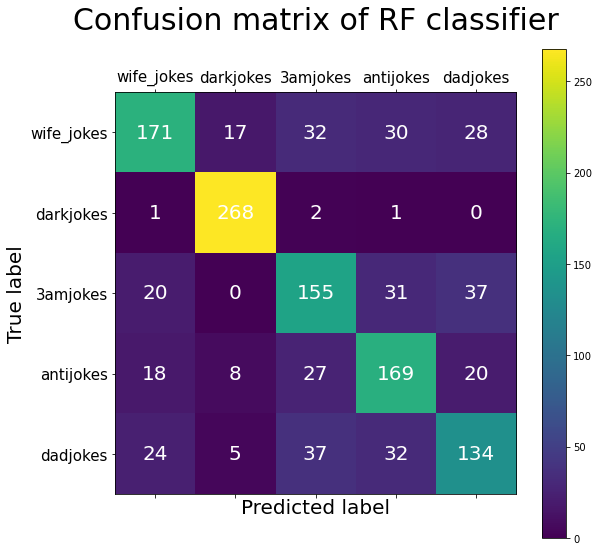

In [1762]:
labels = ['wife_jokes','darkjokes','3amjokes','antijokes','dadjokes']
cm = confusion_matrix(Y_test, y_pred)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of RF classifier\n', fontsize=30)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels, fontsize=15)
ax.set_yticklabels([''] + labels, fontsize=15)
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w", fontsize=20)

plt.show()

In [1763]:
features = X_train.columns

In [1764]:
imp = pd.DataFrame(clf.feature_importances_, index=features, columns=['feature_importance'])
imp = imp.nlargest(20, 'feature_importance')
imp

,feature_importance
nsfw_tag,0.143926
man,0.006478
wife,0.006462
joke,0.005791
woman,0.005607
difference,0.005485
year,0.005069
people,0.004942
bar,0.004576
day,0.004492


Text(0, 0.5, 'features')

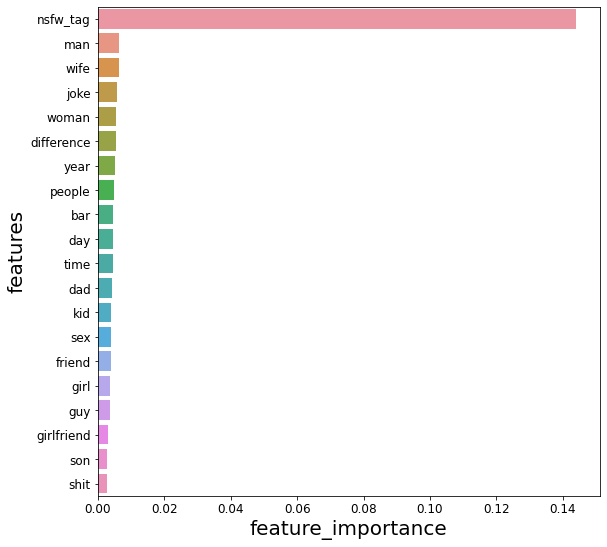

In [1765]:
fig, ax = plt.subplots(figsize=(9,9))
ax.tick_params(axis='both', which='major', labelsize=12)
sns.barplot(data=imp.reset_index(), x='feature_importance', y='index', orient='h', ax=ax)
plt.xlabel("feature_importance", fontsize=20)
plt.ylabel("features", fontsize=20)

In [1766]:
imp3 = pd.DataFrame(clf.feature_importances_, index=features, columns=['feature_importance'])\
        .sort_values('feature_importance',ascending=False).iloc[1:60,:]
imp3

,feature_importance
man,0.006478
wife,0.006462
joke,0.005791
woman,0.005607
difference,0.005485
year,0.005069
people,0.004942
bar,0.004576
day,0.004492
time,0.004456


Text(0, 0.5, 'word features')

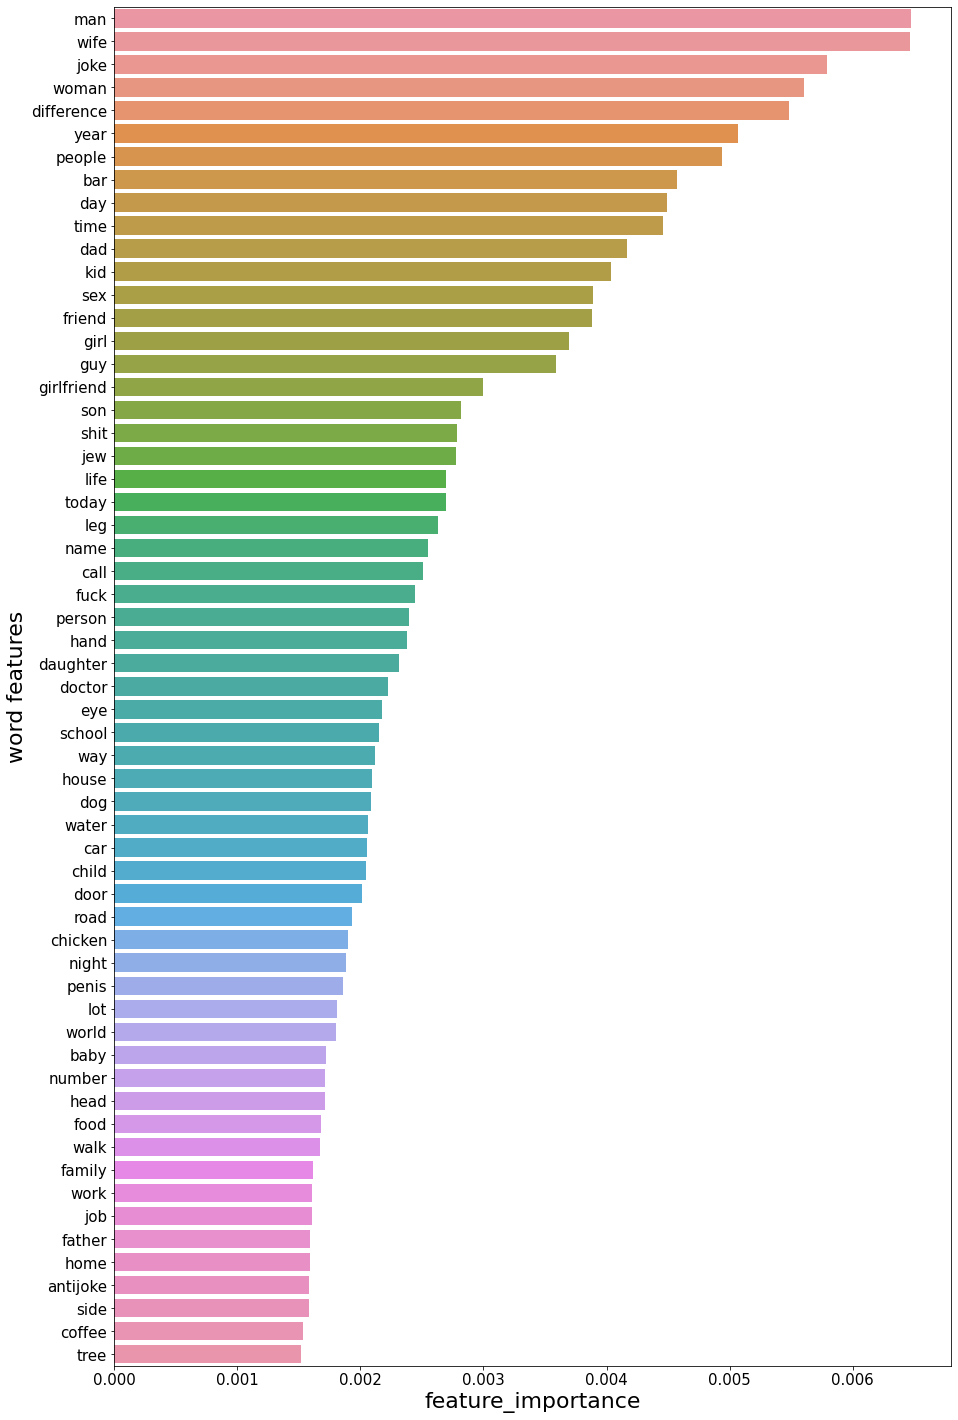

In [1767]:
fig, ax = plt.subplots(figsize=(15,25))
ax.tick_params(axis='both', which='major', labelsize=15)
sns.barplot(data=imp3.reset_index(), x='feature_importance', y='index', orient='h', ax=ax)
plt.xlabel("feature_importance", fontsize=22)
plt.ylabel("word features", fontsize=22)

### POST EDA

## new_label = {'wife_jokes': 1, 'darkjokes': 2, '3amjokes': 3, 'antijokes': 4, 'dadjokes': 5}

In [1768]:
FINAL_df4

,upvotes,ups_ratio,num_comments,nsfw_tag,label,joke_no_stopwords,downvotes,aaa,aaaaughhh,aaarghh,...,zoophile,πd,шутка,ыack,ち乃,トップレス,ㄥモ匕ち,乃丹れれモ刀,匚卄工れム,山尺口れム
0,8984,0.96,122,0,1,monkey smoking joint monkey sitting tree smoking joint lizard walks past lizard looks hey monkey smoking joint come join lizard climbs sits monkey another joint lizard mouth dry going drink river riverbank lizard stoned leans far falls crocodile sees swims stoned lizard helping side asks lizard matter lizard explains crocodile sitting tree smoking joint monkey mouth dry wasted went drink river fell inquisitive crocodile check walks jungle finds tree monkey sitting finishing joint looks hey monkey monkey looks omg duuude water drink,374,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,984,0.97,21,0,1,highly credited esteemed flatearthers flattery nowhere,30,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,619,0.94,23,0,1,nothing built usa anymore bought new tvsays built antennae hell dont,39,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1423,0.96,51,0,1,jokes murderers arent funny unless theyre executed properly,59,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,419,0.93,36,1,1,nsfw another name necrophiliac ghost rider,31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12663,1709,0.96,39,0,3,good pedophiles slow school zones,71,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12664,1712,0.97,13,0,3,supposed speeding ticket officer cop three ride bicycle,52,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12665,1701,0.98,31,0,3,feel bad children antivaxxers arent getting shot life,34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12666,1696,0.98,16,0,3,caught thief stealing coffee homeless people town asked sleep night,34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1771]:
new_cols = list(FINAL_df4.columns)
new_cols[4] = 'LABEL'
FINAL_df4.columns = new_cols

['upvotes',
 'ups_ratio',
 'num_comments',
 'nsfw_tag',
 'LABEL',
 'joke_no_stopwords',
 'downvotes',
 'aaa',
 'aaaaughhh',
 'aaarghh',
 'aaibnltrlidiae',
 'aardvark',
 'ab',
 'abacus',
 'abbey',
 'abduction',
 'abdul',
 'abe',
 'abel',
 'abelist',
 'ability',
 'abooze',
 'abortion',
 'absence',
 'absorbing',
 'abu',
 'abuck',
 'abundance',
 'abuse',
 'abyss',
 'accelerator',
 'accent',
 'acceptance',
 'access',
 'accessory',
 'accident',
 'accomplishment',
 'accord',
 'account',
 'accountant',
 'accuracy',
 'accuse',
 'ace',
 'acenstry',
 'acess',
 'ach',
 'ache',
 'achieve',
 'achievement',
 'achille',
 'achilles',
 'achine',
 'acid',
 'acne',
 'acorn',
 'acquisition',
 'acquit',
 'acre',
 'acronym',
 'act',
 'acting',
 'action',
 'activist',
 'activity',
 'actor',
 'actress',
 'ad',
 'adam',
 'add',
 'adder',
 'adderall',
 'addict',
 'addiction',
 'addition',
 'address',
 'adhd',
 'adherence',
 'adieu',
 'admin',
 'administration',
 'administrator',
 'admiral',
 'admire',
 'admirer'

In [1772]:
FINAL_df4.columns = new_cols

In [1774]:
FINAL_df4.groupby('LABEL')['nsfw_tag'].value_counts()

LABEL  nsfw_tag
1      0           2335
       1           305 
2      1           2639
3      0           2433
       1           44  
4      0           2235
       1           217 
5      0           2399
       1           61  
Name: nsfw_tag, dtype: int64

### Words

In [1775]:
def get_top_topic(word):
    topic = FINAL_df4.groupby('LABEL')[word].sum().idxmax()
    tf_idf_sum = FINAL_df4.groupby('LABEL')[word].sum()[topic]
    return [topic, word, tf_idf_sum]

In [1782]:
# get top 100 features

word_feats = pd.DataFrame(clf.feature_importances_, index=features, columns=['feature_importance'])\
        .sort_values('feature_importance',ascending=False)
word_feats = word_feats.nlargest(101, 'feature_importance').iloc[1:]

word_feats

,feature_importance
man,0.006478
wife,0.006462
joke,0.005791
woman,0.005607
difference,0.005485
...,...
order,0.001128
bird,0.001127
week,0.001121
bartender,0.001113


In [1783]:
top_topics = []
for word in word_feats.reset_index()['index']:
    top_topics.append( get_top_topic(word) )

In [1784]:
len(top_topics)

100

In [1785]:
top_topics

[[1, 'man', 76.67135590318809],
 [5, 'wife', 56.576675402826766],
 [4, 'joke', 56.70346395217292],
 [2, 'woman', 69.68271046207117],
 [2, 'difference', 60.53430904827441],
 [4, 'year', 42.164156902245736],
 [2, 'people', 81.54093735759791],
 [4, 'bar', 56.98699399718233],
 [1, 'day', 36.874098499098615],
 [1, 'time', 33.94694039081149],
 [5, 'dad', 59.11926954782951],
 [2, 'kid', 56.95091176036954],
 [2, 'sex', 35.570347378137335],
 [5, 'friend', 29.083740885568066],
 [2, 'girl', 47.344148026857454],
 [1, 'guy', 37.504099324190186],
 [2, 'girlfriend', 30.680262533419885],
 [5, 'son', 31.73991583233595],
 [4, 'shit', 18.998406275125223],
 [2, 'jew', 38.04633184249306],
 [4, 'life', 23.572792797899357],
 [5, 'today', 26.837717448369975],
 [4, 'leg', 25.450083347859206],
 [4, 'name', 19.36780059237461],
 [3, 'call', 18.060082704546353],
 [4, 'fuck', 15.754076474699627],
 [2, 'person', 28.93118879253564],
 [1, 'hand', 22.082892160369088],
 [5, 'daughter', 21.338998305836917],
 [1, 'doctor'

In [1786]:
top_topics_df = pd.DataFrame(top_topics, columns=['top_topic', 'word_feature', 'sum_tf_idf'])
top_topics_df

,top_topic,word_feature,sum_tf_idf
0,1,man,76.671356
1,5,wife,56.576675
2,4,joke,56.703464
3,2,woman,69.682710
4,2,difference,60.534309
...,...,...,...
95,4,order,11.890747
96,4,bird,10.619885
97,1,week,10.466231
98,1,bartender,17.188512


In [1787]:
# Get tf_idf scores of the top 100 word-features across all topics

groups = top_topics_df.groupby('top_topic').groups

In [1802]:
top_topics_df.iloc[ groups[1] ].sort_values('sum_tf_idf', ascending=False) # wife jokes

,top_topic,word_feature,sum_tf_idf
0,1,man,76.671356
15,1,guy,37.504099
8,1,day,36.874098
9,1,time,33.946940
29,1,doctor,24.048716
27,1,hand,22.082892
78,1,husband,20.925702
38,1,door,20.897686
41,1,night,18.644670
36,1,car,18.254503


In [1801]:
top_topics_df.iloc[ groups[2] ].sort_values('sum_tf_idf', ascending=False) # dark jokes

,top_topic,word_feature,sum_tf_idf
6,2,people,81.540937
3,2,woman,69.682710
4,2,difference,60.534309
11,2,kid,56.950912
14,2,girl,47.344148
19,2,jew,38.046332
12,2,sex,35.570347
31,2,school,32.356547
16,2,girlfriend,30.680263
26,2,person,28.931189


In [1792]:
top_topics_df.iloc[ groups[3] ].sort_values('sum_tf_idf', ascending=False) # 3am jokes

,top_topic,word_feature,sum_tf_idf
24,3,call,18.060083
59,3,yesterday,11.637111
83,3,ball,9.861876
42,3,penis,8.999386
92,3,morning,7.733115


In [1800]:
top_topics_df.iloc[ groups[4] ].sort_values('sum_tf_idf', ascending=False) # anti jokes

,top_topic,word_feature,sum_tf_idf
7,4,bar,56.986994
2,4,joke,56.703464
5,4,year,42.164157
40,4,chicken,29.539870
22,4,leg,25.450083
20,4,life,23.572793
39,4,road,22.880981
81,4,post,20.258383
84,4,horse,19.413478
23,4,name,19.367801


In [1799]:
top_topics_df.iloc[ groups[5] ].sort_values('sum_tf_idf', ascending=False) # dad jokes

,top_topic,word_feature,sum_tf_idf
10,5,dad,59.119270
1,5,wife,56.576675
17,5,son,31.739916
13,5,friend,29.083741
21,5,today,26.837717
28,5,daughter,21.338998
35,5,water,19.201267
30,5,eye,18.090098
65,5,letter,15.213749
43,5,lot,13.257337


### kay Jonah, use these as features for Regression: label, nsfw_tag, tf_idf array
---

### predict either of the three, whichever produces the highest R^2 value: upvotes, downvotes, num_comments